<img src="https://www.pola.rs/share.jpg" width=400 height=200></img>

In [1]:
# !pip install polars altair great-tables colorzero

In [120]:
import polars as pl
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import date

In [6]:
_file_location = './limited-memory-example/yellow_tripdata_2015-01.csv' # ~2GB file

# The history of the `DataFrame`

<img src="./df_hist.png" width=1000 height=500></img>

# Why the name "Polars"?

<font size=5>Because Pandas started it!</font>

<font size=5>Pandas: **Pan**el **Da**ta</font>

<font size=5>Polars: still an ursine, but with the `rs` suffix</font>

# Who?

https://www.ritchievink.com/

# Why?

### 1. Based on the Rust programming language, which is a very interesting language to know, might be very relevant for DS one day. polars has a python and a rust api.
### 2. FAST!
### 3. Can operate on datasets beyond the RAM size
### 4. Come for speed, stay for the API.

# A few words on Rust 

1. C/C++ performance 
2. Memory safety
3. Out of the box parallelism and concurrency
4. Data processing and ML: 
    - [Linfa](https://github.com/rust-ml/linfa) - scikit equivalent
    - [Burn](https://github.com/tracel-ai/burn) - DL package
    - [Polars](https://github.com/pola-rs/polars) - pandas equivalent
    
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Rust_programming_language_black_logo.svg/2048px-Rust_programming_language_black_logo.svg.png" width=50 height=50></img>

<br>
<br>
<br>
<br>
 

## What we will cover:

- Benefits of polars, namely speed
- API differences from Pandas
- Eager API
- Lazy API
- SQL API (Yes, you can use polars directly with SQL)


#### The full dataset contains 12,748,986 rows and 19 columns

#### Reading the full dataset with pandas will kill the kernel...

#### On polars, however...

In [7]:
%time df = pl.read_csv(_file_location)

CPU times: user 4.38 s, sys: 975 ms, total: 5.35 s
Wall time: 3.99 s


#### Forcing it to use the arrow parser is even shorter

In [8]:
%time df = pl.read_csv(_file_location, use_pyarrow=True)

CPU times: user 9.26 s, sys: 3.11 s, total: 12.4 s
Wall time: 2.21 s


In [9]:
type(df)

polars.dataframe.frame.DataFrame

## polars DataFrames have `Schema`s

[`Schemas`](https://docs.pola.rs/api/python/dev/reference/dataframe/api/polars.DataFrame.schema.html) operate like `dict` with keys that are the column names and types that are part of `polars` magic.

Some key methods are:
- `names()` can also be accessed via `df.columns`
- `dtypes()`
- `values()`
- `items()`
- `keys()`
- `to_python()`- will return a `dict`

In [12]:
df.schema

Schema([('VendorID', Int64),
        ('tpep_pickup_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('passenger_count', Int64),
        ('trip_distance', Float64),
        ('pickup_longitude', Float64),
        ('pickup_latitude', Float64),
        ('RateCodeID', Int64),
        ('store_and_fwd_flag', String),
        ('dropoff_longitude', Float64),
        ('dropoff_latitude', Float64),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64)])

In [13]:
df.columns # is equivalent to df.schema.names()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [14]:
df.estimated_size('gb')

1.7216464607045054

## Dtypes

### `polars` uses columnar storage, since logically, every column has 1 type, having a declared type for each column allows for storing and treating each column separately and in an optimized way

In [15]:
df.schema['VendorID']

Int64

In [16]:
dt = df.schema['VendorID']

In [17]:
type(type(dt))

polars.datatypes.classes.DataTypeClass

In [18]:
dt.min(), dt.max()

(<Expr ['-9223372036854775808'] at 0x11B90DD50>,
 <Expr ['9223372036854775807'] at 0x11BC15850>)

In [19]:
dt.is_numeric()

True

In [20]:
dt.is_decimal()

False

In [21]:
dt.is_(df.schema['passenger_count'])

True

# Eager Execution using `polars`

## Basic DataFrame methods

### Creating DataFrames ad hoc

In [24]:
pl.DataFrame({'a': [1,2,3,4], 'b': [4,5,6,7]})

a,b
i64,i64
1,4
2,5
3,6
4,7


### The NYC Dataset

In [25]:
# Our NYC dataset

df.head()

# Note that strings are quoted "some str"

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
i64,datetime[ms],datetime[ms],i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,"""N""",-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.3,-74.001648,40.724243,1,"""N""",-73.994415,40.759109,1,14.5,0.5,0.5,2.0,0.0,0.3,17.8
1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.8,-73.963341,40.802788,1,"""N""",-73.95182,40.824413,2,9.5,0.5,0.5,0.0,0.0,0.3,10.8
1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.5,-74.009087,40.713818,1,"""N""",-74.004326,40.719986,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8
1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.0,-73.971176,40.762428,1,"""N""",-74.004181,40.742653,2,15.0,0.5,0.5,0.0,0.0,0.3,16.3


## Some attributes

In [29]:
df.shape

(12748986, 19)

In [30]:
df.height  # how many rows

12748986

In [31]:
df.width  # how many columns

19

### The `describe()` method

In [32]:
%time df.describe()

CPU times: user 3.03 s, sys: 2.57 s, total: 5.59 s
Wall time: 1.24 s


statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
str,f64,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.2748986e7,"""12748986""","""12748986""",1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,"""12748986""",1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,1.2748986e7,1.2748983e7,1.2748986e7
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
"""mean""",1.521437,"""2015-01-16 14:42:45.468000""","""2015-01-16 14:56:56.208000""",1.681491,13.45913,-72.561838,39.972823,1.036901,null,-72.609039,39.999614,1.386712,11.905659,0.308279,0.497799,1.853814,0.243498,0.283143,15.108295
"""std""",0.49954,null,null,1.337924,9844.094218,10.125104,5.578691,0.673224,null,9.966037,5.487742,0.498861,10.302537,0.591664,0.035342,1106.432314,1.527171,0.069086,1106.503247
"""min""",1.0,"""2015-01-01 00:00:00""","""2015-01-01 00:00:00""",0.0,0.0,-121.925812,0.0,1.0,"""N""",-740.166687,-9.029157,1.0,-450.0,-79.0,-0.5,-92.42,-26.0,0.0,-450.3
"""25%""",1.0,"""2015-01-09 09:26:51""","""2015-01-09 09:44:29""",1.0,1.0,-73.991684,40.735542,1.0,null,-73.991196,40.73436,1.0,6.5,0.0,0.5,0.0,0.0,0.3,8.16
"""50%""",2.0,"""2015-01-16 11:42:49""","""2015-01-16 11:56:56""",1.0,1.68,-73.981598,40.753143,1.0,null,-73.979759,40.753624,1.0,9.0,0.0,0.5,1.0,0.0,0.3,11.16
"""75%""",2.0,"""2015-01-23 19:15:29""","""2015-01-23 19:29:04""",2.0,3.0,-73.966621,40.76757,1.0,null,-73.962456,40.768803,2.0,13.5,0.5,0.5,2.06,0.0,0.3,16.3
"""max""",2.0,"""2015-01-31 23:59:59""","""2016-02-02 16:30:52""",9.0,1.5420e7,78.662651,404.700012,99.0,"""Y""",85.274025,459.533325,5.0,4008.0,999.99,0.5,3950588.8,1450.09,0.3,3950611.6


## Indexing: No `index` attribute, no `loc`/`iloc` methods... 
instead one can just refer to row number (0 based indexing)

In [35]:
df[0,0]

2

In [36]:
df['VendorID']

VendorID
i64
2
1
1
1
1
…
1
1
1


In [37]:
df[0,'VendorID']

2

In [38]:
df[1000:1004,['tpep_dropoff_datetime', 'pickup_longitude']]

tpep_dropoff_datetime,pickup_longitude
datetime[ms],f64
2015-01-07 20:45:40,-73.995155
2015-01-07 20:43:41,-73.960281
2015-01-07 20:53:31,-73.967667
2015-01-07 21:02:08,-73.986908


In [39]:
type(df[0,:])

polars.dataframe.frame.DataFrame

In [40]:
type(df[:,0])

polars.series.series.Series

## A common `pandas` pattern is to use masks for filtering...

```python
df = pd.read_csv('/somewhere/something.csv')

mask = df['age'] > 30

df = df[mask] # would filter the DataFrame

```

## ... but it's not supported in `polars` ...

In [41]:
mask = df['VendorID'] == 1

In [42]:
mask.head(5)

VendorID
bool
false
true
true
true
true


In [43]:
df[mask, 'passenger_count'] # this should fail

TypeError: selecting rows by passing a boolean mask to `__getitem__` is not supported

Hint: Use the `filter` method instead.

## ... we'll get to `filter` later

## Other indexing methods `rows`/`iter_rows`/`rows_by_key`

In [44]:
df_ex = pl.DataFrame(
     {
         "x": ["a", "b", "b", "a"],
         "y": [1, 2, 3, 4],
         "z": [0, 3, 6, 9],
     }
)

df_ex

x,y,z
str,i64,i64
"""a""",1,0
"""b""",2,3
"""b""",3,6
"""a""",4,9


### <font color='red'>Materialization Warning:</font> Use with caution: `rows`

Unlike `pandas`, `polars` stores the values in a columnar way which can be more dense<br>
This method will "create" all the rows as python primitives

In [47]:
df_ex.rows() # can be very expensive

[('a', 1, 0), ('b', 2, 3), ('b', 3, 6), ('a', 4, 9)]

In [48]:
df_ex.rows(named=True) # or use df_ex.to_dicts()

[{'x': 'a', 'y': 1, 'z': 0},
 {'x': 'b', 'y': 2, 'z': 3},
 {'x': 'b', 'y': 3, 'z': 6},
 {'x': 'a', 'y': 4, 'z': 9}]

### Memory effective option is using iterators: `iter_rows`

In [49]:
for row in df_ex.iter_rows():
    print(row)

('a', 1, 0)
('b', 2, 3)
('b', 3, 6)
('a', 4, 9)


In [50]:
_sum = 0
for row in df_ex.iter_rows():
    _sum += row[1]
    
print(f"the sum of the 2nd column is {_sum}")

the sum of the 2nd column is 10


In [51]:
# value of last column in each row as a list
[row[-1] for row in df_ex.iter_rows()]

[0, 3, 6, 9]

In [52]:
# value of named in each row as a list
[row['x'] for row in df_ex.iter_rows(named=True)]

['a', 'b', 'b', 'a']

### <font color='red'>Materialization Warning:</font> `rows_by_key`

In [53]:
df_ex

x,y,z
str,i64,i64
"""a""",1,0
"""b""",2,3
"""b""",3,6
"""a""",4,9


In [54]:
df_ex.rows_by_key(key=['x'])

defaultdict(list, {'a': [(1, 0), (4, 9)], 'b': [(2, 3), (3, 6)]})

In [55]:
df_ex.rows_by_key(key=['x'], named=True)

defaultdict(list,
            {'a': [{'y': 1, 'z': 0}, {'y': 4, 'z': 9}],
             'b': [{'y': 2, 'z': 3}, {'y': 3, 'z': 6}]})

###  Unsure? Confused? You can always go back `to_pandas` or `to_numpy` 

In [56]:
df_ex.to_pandas()

,x,y,z
0,a,1,0
1,b,2,3
2,b,3,6
3,a,4,9


In [57]:
df_ex.to_numpy()

array([['a', 1, 0],
       ['b', 2, 3],
       ['b', 3, 6],
       ['a', 4, 9]], dtype=object)

## Expressions

### (The diagram is my own)

<img src="./api_layers.png" height=1200 width=400></img>

In [58]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [59]:
c1 = pl.col("VendorID") # unlike df['VendorID']

In [64]:
c1

<Expr ['col("VendorID")'] at 0x32E96DA10>

In [65]:
type(c1)

polars.expr.expr.Expr

In [66]:
df.select(c1).head(3)

VendorID
i64
2
1
1


In [67]:
df.select(pl.col("VendorID", "pickup_longitude"))

VendorID,pickup_longitude
i64,f64
2,-73.993896
1,-74.001648
1,-73.963341
1,-74.009087
1,-73.971176
…,…
1,-73.951988
1,-73.982742
1,-73.979324


In [68]:
df.select("VendorID", "pickup_longitude")

VendorID,pickup_longitude
i64,f64
2,-73.993896
1,-74.001648
1,-73.963341
1,-74.009087
1,-73.971176
…,…
1,-73.951988
1,-73.982742
1,-73.979324


### Filtering using expressions

In [69]:
mask = pl.col("pickup_longitude") > -73.

In [70]:
mask # Not materialized, just the instruction

<Expr ['[(col("pickup_longitude")) > (…'] at 0x32E8364D0>

In [71]:
type(mask)

polars.expr.expr.Expr

In [72]:
type((pl.col("pickup_longitude") > -73.) & (pl.col("passenger_count") < 1))

polars.expr.expr.Expr

In [73]:
df.filter(
    (pl.col("pickup_longitude") > -73.) &
    (pl.col("passenger_count") < 1)
)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
i64,datetime[ms],datetime[ms],i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
1,2015-01-14 09:59:32,2015-01-14 10:03:36,0,0.7,0.0,0.0,1,"""N""",-73.989235,40.769493,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8
1,2015-01-15 22:51:35,2015-01-15 23:10:11,0,5.6,0.0,0.0,1,"""N""",-73.923241,40.743538,1,19.0,0.5,0.5,4.05,0.0,0.3,24.35
1,2015-01-01 02:52:01,2015-01-01 03:15:09,0,4.2,0.0,0.0,1,"""N""",-73.952553,40.7141,1,18.0,0.5,0.5,3.85,0.0,0.0,23.15
1,2015-01-31 00:39:09,2015-01-31 00:48:51,0,1.5,0.0,0.0,1,"""N""",-73.981911,40.736889,1,8.0,0.5,0.5,1.85,0.0,0.3,11.15
1,2015-01-24 20:07:52,2015-01-24 20:10:52,0,0.5,0.0,0.0,1,"""N""",-73.97126,40.758507,1,4.0,0.5,0.5,1.55,0.0,0.3,6.85
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2015-01-16 21:26:44,2015-01-16 21:39:23,0,3.0,0.0,0.0,1,"""N""",-73.970886,40.693371,1,12.0,0.5,0.5,3.3,0.0,0.3,16.6
1,2015-01-11 11:31:09,2015-01-11 11:38:52,0,1.5,0.0,0.0,1,"""N""",0.0,0.0,2,7.5,0.0,0.5,0.0,0.0,0.3,8.3
1,2015-01-18 01:47:30,2015-01-18 01:55:03,0,1.4,0.0,0.0,1,"""N""",-74.004585,40.742241,1,7.0,0.5,0.5,0.11,0.0,0.3,8.41


### Adding columns - the wrong way (another common `pandas` pattern)

In [74]:
df['x'] = 1 # this should fail

TypeError: DataFrame object does not support `Series` assignment by index

Use `DataFrame.with_columns`.

### Adding columns - the right way

In [75]:
df = df.with_columns(pl.Series('x', [1]*df.shape[0]))

In [76]:
df.select('x').head()

x
i64
1
1
1
1
1


### Using literals: a safer way to work with constants as expressions

In [77]:
_lit = pl.lit(1)
_lit

<Expr ['dyn int: 1'] at 0x32E954190>

In [78]:
type(_lit)

polars.expr.expr.Expr

In [79]:
df = df.with_columns(pl.lit(2).alias('y'))

In [80]:
df.select('y', 'x', 'VendorID').head()

y,x,VendorID
i32,i64,i64
2,1,2
2,1,1
2,1,1
2,1,1
2,1,1


### Using expressions to add columns

In [81]:
df_ex

x,y,z
str,i64,i64
"""a""",1,0
"""b""",2,3
"""b""",3,6
"""a""",4,9


In [82]:
df_ex.select(pl.col('x'), pl.col('y')+1)

x,y
str,i64
"""a""",2
"""b""",3
"""b""",4
"""a""",5


In [83]:
df_ex.select( 
    
    (pl.col('y')/2).alias('y/2'),
    
    (2/pl.col('y')).alias('2/y'),
    
    (pl.col('y') + pl.col('z')).alias('y+z'),
    
    pl.col('z').arctan().alias('arctan(z)'),
    
    pl.col('z').arctan().ceil().alias('ceil(arctan(z))'),
    
    (pl.col('z')-5).abs().alias('abs(z-5)'),
    
    pl.col('z').is_in([1,2,3]).alias('z is in (1,2,3)'),
    
    pl.col('z').pow(2).alias('z**2'),
    
    (pl.col('y')**2).alias('y**2')
    
)

y/2,2/y,y+z,arctan(z),ceil(arctan(z)),abs(z-5),"z is in (1,2,3)",z**2,y**2
f64,f64,i64,f64,f64,i64,bool,i64,i64
0.5,2.0,1,0.0,0.0,5,false,0,1
1.0,1.0,5,1.249046,2.0,2,true,9,4
1.5,0.666667,9,1.405648,2.0,1,false,36,9
2.0,0.5,13,1.460139,2.0,4,false,81,16


### Casting types

In [84]:
df.select(pl.col('VendorID').cast(pl.String))

VendorID
str
"""2"""
"""1"""
"""1"""
"""1"""
"""1"""
…
"""1"""
"""1"""
"""1"""


### But I really like my python function...

In [87]:
def my_func(x):
    return x+2

In [88]:
df.select(
    original=pl.col('VendorID'), 
    plus_2=pl.col('VendorID').pipe(my_func)
)

original,plus_2
i64,i64
2,4
1,3
1,3
1,3
1,3
…,…
1,3
1,3
1,3


### Case when..

In [89]:
# add a month_name column
df = df.with_columns(
    (pl.col("tpep_pickup_datetime").dt.strftime("%b").alias("month_name")),
    (pl.col("tpep_pickup_datetime").dt.strftime("%d").alias("month_day").cast(pl.Int64)),
)

In [90]:
df.select('tpep_pickup_datetime', 'month_name', 'month_day')

tpep_pickup_datetime,month_name,month_day
datetime[ms],str,i64
2015-01-15 19:05:39,"""Jan""",15
2015-01-10 20:33:38,"""Jan""",10
2015-01-10 20:33:38,"""Jan""",10
2015-01-10 20:33:39,"""Jan""",10
2015-01-10 20:33:39,"""Jan""",10
…,…,…
2015-01-10 19:01:44,"""Jan""",10
2015-01-10 19:01:44,"""Jan""",10
2015-01-10 19:01:44,"""Jan""",10


In [91]:
my_col = (
    pl.when(pl.col('month_day') <= 10)
      .then(pl.lit('first 10 days'))
      .when(pl.col('month_day') <= 20)
      .then(pl.lit('middle 10 days'))
      .otherwise(pl.lit('last 10 days'))
)

In [92]:
type(my_col)

polars.expr.expr.Expr

In [93]:
df = df.with_columns(my_col.alias('day_group'))

In [94]:
df.select('tpep_pickup_datetime', 'day_group')

tpep_pickup_datetime,day_group
datetime[ms],str
2015-01-15 19:05:39,"""middle 10 days"""
2015-01-10 20:33:38,"""first 10 days"""
2015-01-10 20:33:38,"""first 10 days"""
2015-01-10 20:33:39,"""first 10 days"""
2015-01-10 20:33:39,"""first 10 days"""
…,…
2015-01-10 19:01:44,"""first 10 days"""
2015-01-10 19:01:44,"""first 10 days"""
2015-01-10 19:01:44,"""first 10 days"""


### Removing columns

In [95]:
df = df.drop('x') # or an iterator or a pointer to a pl.col

## Group by

<font color='red'>A note on api method names:</font> words will always be separated by an underscore `group_by`, `value_counts` etc...

### agg expressions

In [96]:
pl.col('passenger_count').sum()

<Expr ['col("passenger_count").sum()'] at 0x11F10E590>

In [97]:
type(pl.col('passenger_count').sum())

polars.expr.expr.Expr

In [98]:
df.group_by('month_name', 'day_group').agg(
    pl.len().alias('trips'), # count(1) like SQL
    pl.col('passenger_count').sum().alias('passengers'),
    pl.col('trip_distance').sum().alias('distance_driven'),
)

month_name,day_group,trips,passengers,distance_driven
str,str,u32,i64,f64
"""Jan""","""last 10 days""",4405497,7353743,6.4019e7
"""Jan""","""middle 10 days""",4288724,7171697,4.0116e7
"""Jan""","""first 10 days""",4054765,6911863,6.7455e7


### `group_by_dynamic`

In [99]:
result = (
    df.filter(pl.col('month_day') <= 3)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
)
result

tpep_pickup_datetime,trips,passengers,distance_driven
datetime[ms],u32,i64,f64
2015-01-01 00:00:00,28312,51700,82489.09
2015-01-01 01:00:00,31707,58584,99258.12
2015-01-01 02:00:00,28068,51507,91865.7
2015-01-01 03:00:00,24288,44134,84036.57
2015-01-01 04:00:00,17081,30799,63055.28
…,…,…,…
2015-01-03 19:00:00,25667,46194,3240988.5
2015-01-03 20:00:00,20531,36959,54915.04
2015-01-03 21:00:00,21399,38224,56920.38


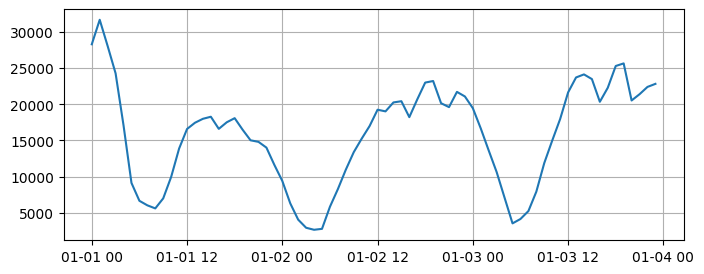

In [100]:
plt.figure(figsize=(8,3))
plt.plot(result['tpep_pickup_datetime'], result['trips'])
plt.grid()
plt.show()

<font color='red'>Note:</font>`polars` supports built-in plotting methods like `pandas`, but not using matplotlib. It uses `altair` instead, which works on `pandas` natively, not sure why this package was chosen for integration...

In [101]:
result.plot.line(x='tpep_pickup_datetime', y='trips').properties(
    width=600,
    height=200
)

alt.Chart(...)

### SQL-like analytic functions are also available

In [102]:
window = {
    'partition_by': [None],
    'order_by': ['tpep_pickup_datetime']
}

result = (
    df.filter(pl.col('month_day') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('trips').cum_sum()
                      .over(**window)
                      .alias('cumulative_trips'))
        .with_columns((pl.col('cumulative_trips') / pl.col('trips').sum().over([None])).alias('F'))
        .rename({'tpep_pickup_datetime':'hour'})
)
result

hour,trips,cumulative_trips,F
datetime[ms],u32,u32,f64
2015-01-01 00:00:00,28312,28312,0.074112
2015-01-01 01:00:00,31707,60019,0.157112
2015-01-01 02:00:00,28068,88087,0.230586
2015-01-01 03:00:00,24288,112375,0.294165
2015-01-01 04:00:00,17081,129456,0.338878
…,…,…,…
2015-01-01 19:00:00,16485,326581,0.854893
2015-01-01 20:00:00,15017,341598,0.894203
2015-01-01 21:00:00,14801,356399,0.932947


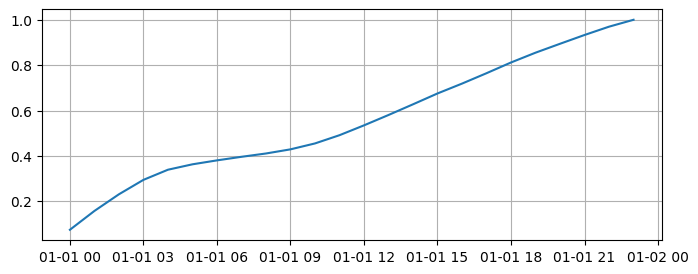

In [103]:
_, ax = plt.subplots(figsize=(8,3))
ax.plot(result['hour'], result['F'])
ax.grid()

plt.show()

### Joins

In [104]:
result1 = (
    df.filter(pl.col('month_day') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)

result2 = (
    df.filter(pl.col('month_day') == 2)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)

result1.join(result2, on='hour')

tpep_pickup_datetime,trips,hour,tpep_pickup_datetime_right,trips_right
datetime[ms],u32,str,datetime[ms],u32
2015-01-01 00:00:00,28312,"""00""",2015-01-02 00:00:00,9388
2015-01-01 01:00:00,31707,"""01""",2015-01-02 01:00:00,6291
2015-01-01 02:00:00,28068,"""02""",2015-01-02 02:00:00,4027
2015-01-01 03:00:00,24288,"""03""",2015-01-02 03:00:00,2905
2015-01-01 04:00:00,17081,"""04""",2015-01-02 04:00:00,2626
…,…,…,…,…
2015-01-01 19:00:00,16485,"""19""",2015-01-02 19:00:00,23227
2015-01-01 20:00:00,15017,"""20""",2015-01-02 20:00:00,20153
2015-01-01 21:00:00,14801,"""21""",2015-01-02 21:00:00,19611


### Pivot

In [121]:
(
    df
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%Y-%m-%d').alias('date'))
        .pivot(on='hour', index='date', values='trips')
)

date,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""2015-01-01""",28312,31707,28068,24288,17081,9112,6637,6011,5586,6977,9949,13870,16582,17448,17994,18279,16602,17511,18082,16485,15017,14801,14005,11610
"""2015-01-02""",9388,6291,4027,2905,2626,2755,5811,8256,10946,13373,15243,16999,19252,19023,20260,20429,18223,20680,23008,23227,20153,19611,21722,21088
"""2015-01-03""",19467,16660,13607,10620,7061,3512,4120,5216,7908,11869,14975,17966,21644,23718,24143,23494,20350,22295,25305,25667,20531,21399,22409,22833
"""2015-01-04""",20632,17494,13485,9842,6384,3365,3625,4734,7070,10153,14304,16325,18101,18639,18722,18234,18056,18257,18498,18494,17529,14063,12639,10203
"""2015-01-05""",7653,4685,3076,2071,2310,4218,11095,18866,22131,19602,16290,16428,17022,17127,18916,19897,17718,21727,26144,25655,22028,19814,16256,12725
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2015-01-27""",115,52,39,14,24,50,145,374,1003,2279,3748,4857,5798,6271,7119,8306,9683,12193,14974,13395,12064,12545,11382,9070
"""2015-01-28""",5491,3267,2178,1518,1705,3676,11160,19889,23070,21000,17453,16929,17196,16989,18450,18891,16780,20853,26448,27252,25293,24635,23451,16618
"""2015-01-29""",10608,5981,3920,2685,2579,4283,12121,21535,24504,22595,19828,19009,19940,19710,21245,20932,17403,21413,27437,28562,28124,28043,26452,23076


### Implode

In [125]:
imploded_df = (
    df
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%Y-%m-%d').alias('date'))
        .sort('date', 'hour')
        .group_by('date')
        .agg(pl.col('trips').implode())
        .sort('date')
        .with_columns(
            pl.col('date').cast(pl.Date),
            pl.col('trips').list.get(0)
        )
#         .filter(pl.col('date') <= pl.lit(date(2015,1,5)))
#         .style
#         .fmt_nanoplot(columns='trips')
)

In [126]:
imploded_df

date,trips
date,list[u32]
2015-01-01,"[28312, 31707, … 11610]"
2015-01-02,"[9388, 6291, … 21088]"
2015-01-03,"[19467, 16660, … 22833]"
2015-01-04,"[20632, 17494, … 10203]"
2015-01-05,"[7653, 4685, … 12725]"
…,…
2015-01-27,"[115, 52, … 9070]"
2015-01-28,"[5491, 3267, … 16618]"
2015-01-29,"[10608, 5981, … 23076]"


#### great-tables integration

In [128]:
imploded_df.filter(pl.col('date') < pl.lit(date(2015,1,5))).style

date,trips
2015-01-01,"[28312, 31707, 28068, 24288, 17081, 9112, 6637, 6011, 5586, 6977, 9949, 13870, 16582, 17448, 17994, 18279, 16602, 17511, 18082, 16485, 15017, 14801, 14005, 11610]"
2015-01-02,"[9388, 6291, 4027, 2905, 2626, 2755, 5811, 8256, 10946, 13373, 15243, 16999, 19252, 19023, 20260, 20429, 18223, 20680, 23008, 23227, 20153, 19611, 21722, 21088]"
2015-01-03,"[19467, 16660, 13607, 10620, 7061, 3512, 4120, 5216, 7908, 11869, 14975, 17966, 21644, 23718, 24143, 23494, 20350, 22295, 25305, 25667, 20531, 21399, 22409, 22833]"
2015-01-04,"[20632, 17494, 13485, 9842, 6384, 3365, 3625, 4734, 7070, 10153, 14304, 16325, 18101, 18639, 18722, 18234, 18056, 18257, 18498, 18494, 17529, 14063, 12639, 10203]"


In [129]:
imploded_df.filter(pl.col('date') < pl.lit(date(2015,1,5))).style.fmt_nanoplot(columns='trips')

GT(_tbl_data=shape: (4, 2)
┌────────────┬─────────────────────────┐
│ date       ┆ trips                   │
│ ---        ┆ ---                     │
│ date       ┆ list[u32]               │
╞════════════╪═════════════════════════╡
│ 2015-01-01 ┆ [28312, 31707, … 11610] │
│ 2015-01-02 ┆ [9388, 6291, … 21088]   │
│ 2015-01-03 ┆ [19467, 16660, … 22833] │
│ 2015-01-04 ┆ [20632, 17494, … 10203] │
└────────────┴─────────────────────────┘, _body=<great_tables._gt_data.Body object at 0x334545250>, _boxhead=Boxhead([ColInfo(var='date', type=<ColInfoTypeEnum.default: 1>, column_label='date', column_align='right', column_width=None), ColInfo(var='trips', type=<ColInfoTypeEnum.default: 1>, column_label='trips', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3341a8390>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x334135fd0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x3340bb490>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='c

## SQL API (Lazy by definition)

<img src="./sql_api.png" width="400" height="400"></img>

In [130]:
result1 = (
    df.filter(pl.col('month_day') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
    .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)


In [131]:
result1

tpep_pickup_datetime,trips,passengers,distance_driven,hour
datetime[ms],u32,i64,f64,str
2015-01-01 00:00:00,28312,51700,82489.09,"""00"""
2015-01-01 01:00:00,31707,58584,99258.12,"""01"""
2015-01-01 02:00:00,28068,51507,91865.7,"""02"""
2015-01-01 03:00:00,24288,44134,84036.57,"""03"""
2015-01-01 04:00:00,17081,30799,63055.28,"""04"""
…,…,…,…,…
2015-01-01 19:00:00,16485,29930,45510.07,"""19"""
2015-01-01 20:00:00,15017,27319,46798.67,"""20"""
2015-01-01 21:00:00,14801,26886,44651.48,"""21"""


In [132]:
pl.sql("""select avg(distance_driven) as avg_distance from result1""")

#### In order to see the result we should use `collect`

In [140]:
pl.sql("""select avg(distance_driven) as avg_distance from result1""").collect()

avg_distance
f64
51498.824583


#### Or, use the `eager=True` attribute

In [141]:
pl.sql("""select avg(distance_driven) as avg_distance from result1""", eager=True)

avg_distance
f64
51498.824583


#### SQL Joins

In [143]:
result2 = (
    df.filter(pl.col('month_day') == 3) # <-- 2nd day
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
    .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)

In [144]:
result = pl.sql("""
    select 
        t1.hour, 
        t1.distance_driven as dist1, 
        t2.distance_driven as dist2
    from result1 as t1 join result2 as t2 on t1.hour = t2.hour
    order by 1
""")

mat = result.collect()

In [145]:
mat

hour,dist1,dist2
str,f64,f64
"""00""",82489.09,59056.22
"""01""",99258.12,49830.61
"""02""",91865.7,41690.15
"""03""",84036.57,35877.24
"""04""",63055.28,28130.54
…,…,…
"""19""",45510.07,3240988.5
"""20""",46798.67,54915.04
"""21""",44651.48,56920.38


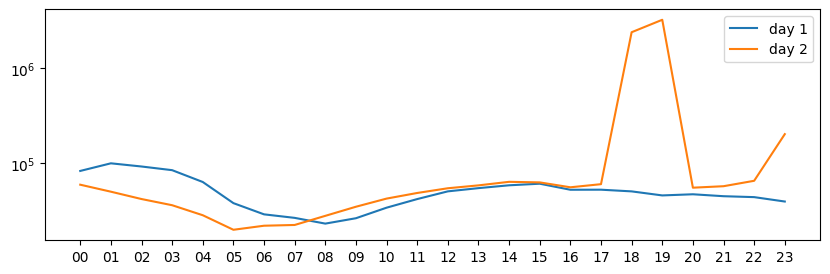

In [148]:
plt.figure(figsize=(10,3))
plt.plot(mat['hour'], mat['dist1'], label='day 1')
plt.plot(mat['hour'], mat['dist2'], label='day 2')
plt.legend()
plt.yscale('symlog')
plt.show()

## The SQL API also supports `pandas` DataFrames 

In [149]:
pd_df = pd.DataFrame({'key':[1,2,3], 'a':[0,0,1]})
pl_df = pl.DataFrame({'key':[1,2,3], 'b':[1,0,0]})

pl.sql("""
    select
        pd_df.key,
        pd_df.a,
        pl_df.b,
        greatest(pd_df.a, pl_df.b) as max_ab,
        sum(greatest(pd_df.a, pl_df.b)) over(order by key) as cumsum_max_ab
    from
        pd_df join pl_df on pd_df.key = pl_df.key
""").collect()

key,a,b,max_ab,cumsum_max_ab
i64,i64,i64,i64,i64
1,0,1,1,1
2,0,0,0,1
3,1,0,1,2


## What is supported in SQL?

### The polars team claim they are trying to have everything that PostgreSQL support, but it's still wip

### What's supported right now

- `SELECT`
- `DISTINCT`
- `FROM`
- `JOIN (CROSS JOIN, FULL JOIN, INNER JOIN, [LEFT | RIGHT] [ANTI | SEMI] JOIN`, 
- `WHERE`
- `GROUP BY`
- `HAVING`
- `ORDER BY`
- `LIMIT/OFFSET`
- `EXCEPT`
- `INTERSECT`
- `UNION [ALL]`
- `UNNEST`
- `WITH`
- `OVER`
- Lots and lots of functions...

### Not supported

- `QUALIFY`

## Working with BigQuery

There is no direct connector to BigQuery, however, BigQuery queries can be transfered in Arrow format

```python
import polars as pl
from google.cloud import bigquery

client = bigquery.Client()

# Perform a query.
QUERY = """
    SELECT a,b,c
    FROM some_table 
    WHERE condition
    LIMIT 100""""

query_job = client.query(QUERY)  
rows = query_job.result() 

df = pl.from_arrow(rows.to_arrow())
```

# Lazy API

So far we've been showing the 'eager' api, that performs calculations 'as they come'.

The **lazy** api works in a 'tell me what you want to do, and let me do it on my own' fashion

In [157]:
lf = pl.scan_csv(_file_location)
lf

In [158]:
type(lf)

polars.lazyframe.frame.LazyFrame

### What the hell is $\pi */19$?

It's part of **relational algebra** (the math behind SQL), and it means:
- $\pi$ is the projection operator (in this case it just means 'select')
- ... the set of all rows * 
- ... over 19 columns

In [159]:
lf = (
    pl.scan_csv(_file_location)
    .with_columns(pl.col('tpep_pickup_datetime').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"))
    .filter(pl.col('VendorID') == 1)
    .sort('tpep_pickup_datetime')
    .group_by_dynamic('tpep_pickup_datetime', every='1h')
    .agg(
        pl.len().alias('trips'),
        pl.col('passenger_count').sum().alias('passengers'),
        pl.col('trip_distance').sum().alias('distance_driven')
    )
)

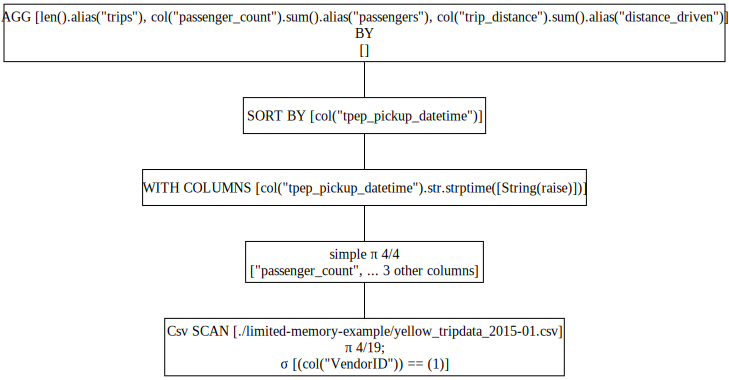

In [160]:
lf.show_graph()

The $\sigma$ operator is another of operation in Relational Algebra that is related to filters.

### What can we know about the LazyFrame without materializing it?

#### <font color='red'>Materialization Warning:</font> calling `columns` will perform materialization

In [161]:
# should warn with PerformanceWarning
%time lf.columns

CPU times: user 703 µs, sys: 3.81 ms, total: 4.51 ms
Wall time: 3.34 ms


<timed eval>:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.


['tpep_pickup_datetime', 'trips', 'passengers', 'distance_driven']

In [162]:
# better to use 'collect_schema'
%time lf.collect_schema()

CPU times: user 84 µs, sys: 19 µs, total: 103 µs
Wall time: 99.2 µs


Schema([('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)),
        ('trips', UInt32),
        ('passengers', Int64),
        ('distance_driven', Float64)])

### But there's no data here, just instructions. So using indices for example, will result in an error

In [ ]:
lf[0:1,'trips'] # this should fail

### Materialization has to be explicit, using `collect` to get a `polars.DataFrame`

In [ ]:
%time lazy_result = lf.collect()

In [ ]:
def eager_time_test():
    return (
        pl.read_csv(_file_location)
        .with_columns(pl.col('tpep_pickup_datetime').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"))
        .filter(pl.col('VendorID') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
    )

In [ ]:
%time eager_result = eager_time_test()

In [ ]:
%time lazy_result = lf.collect() 

In [ ]:
lazy_result.head()

In [ ]:
eager_result.head()

In [ ]:
lazy_result.equals(eager_result)

### Profiling

In [ ]:
result, profile_result = lf.profile(show_plot=True)

In [ ]:
profile_result

In [ ]:
_, profile_result = lf.profile(show_plot=True, predicate_pushdown=False, projection_pushdown=False)

In [ ]:
profile_result

### Directly creating LazyDataFrame

In [ ]:
pl.DataFrame({'a': [1,2,3]}).lazy()

## If you don't want to run the entire computation, just to check if you did things correctly

### Use `head(n).collect()`

In [ ]:
result.head(2).collect()

# Summary:

1. Used correctly, `polars` is superior to `pandas` in terms of performance<br>
2. Not limited to RAM when using lazy execution<br>
2. SQL api, Lazy execution are very handy<br>
3. I personally prefer the functional expression API<br>
4. Multiple connectors are availble (parquet, Excel, CSV, ...)<br>
5. As of Dec 2024 numpy/pandas conversion happens behind the scenes when we fit models and plot stuff, so there is no speed up on scikit-learn/LightGBM/catboost/matplotlib - but, polars is moving quickly and we might see more and more direct integrations<br>
6. Rust - since this is A rapidly growing community, it might have some future for DS/Analytics too, and then polars will be rust's pandas equivalent<br>

## Bonus: `great-tables`

Integrates seamlessly with `polars` you can also use the `selectors` directly when selecting columns.

In [ ]:
from great_tables import GT, md, html, nanoplot_options
from colorzero import *

In [ ]:
_file_location = './limited-memory-example/yellow_tripdata_2015-01.csv'
df = pl.read_csv(_file_location)

In [ ]:
bw = (
    df
    .sort(pl.col('tpep_pickup_datetime'), descending=False)
    .group_by_dynamic(pl.col('tpep_pickup_datetime').str.to_datetime('%Y-%m-%d %H:%M:%S'), every="1w")
    .agg(
        pl.col('passenger_count').mean().alias('average_passenger_count'),
        pl.col('trip_distance').mean().alias('average_trip_distance'),
        pl.col('fare_amount').mean(),
        pl.col('extra').mean(),
        pl.col('mta_tax').mean(),
        pl.col('tip_amount').mean(),
        pl.col('tolls_amount').mean(),
        pl.col('total_amount').mean())
    ).rename(mapping={'tpep_pickup_datetime':'week'})

bw2 = (
    df
    .sort(pl.col('tpep_pickup_datetime'), descending=False)
    .group_by_dynamic(pl.col('tpep_pickup_datetime').str.to_datetime('%Y-%m-%d %H:%M:%S'), every="1d")
    .agg(pl.col('passenger_count').sum().alias('passenger_count_daily'))
    .rename(mapping={'tpep_pickup_datetime':'day'})
    .sort(pl.col('day'), descending=False)
    .group_by_dynamic(pl.col('day'), every="1w")
    .agg(pl.col('passenger_count_daily').implode())
    .with_columns(pl.col('passenger_count_daily').list.get(0))
    .rename(mapping={'day':'week'})
    )

gt1 = (
    bw.join(bw2, on='week', how='inner').style
        .tab_header('NYC Taxi dataset', subtitle=f"Weekly statistics between Dec 29, 2014 to Jan 26, 2015")
        .tab_stub(rowname_col='week')
        .tab_source_note(source_note='Kaggle, July 2017. https://www.kaggle.com/competitions/nyc-taxi-trip-duration')
        .tab_spanner(label='Averages', columns=['average_passenger_count', 'average_trip_distance'])
        .tab_spanner(label='Avg. Costs', columns=['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'])
        .fmt_currency(columns=['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'])
        .fmt_date(columns=['week'], date_style='m_day_year')
        .fmt_number(columns=['average_passenger_count', 'average_trip_distance'], compact=True)
        .fmt_nanoplot(columns='passenger_count_daily', autoscale=True)
        .cols_label(
            average_passenger_count=html('Passenger<br>count'),
            average_trip_distance=html('Trip<br>distance'),
            fare_amount=html('Fare'),
            extra='Extra',
            mta_tax='MTA tax',
            tip_amount='Tip',
            tolls_amount=html('Tolls'),
            total_amount=html('Total'),
            passenger_count_daily=html('Passenger count<br>(daily)')
        )
)
low_col = Color('lime') - Saturation(0.4)
high_col = Color('yellow') - Saturation(0.2)
gt2 = (
    gt1
    .data_color(
        palette=[low_col.html, high_col.html], 
        columns=[k for k,v in bw.schema.items() 
                 if v.is_numeric() 
                 and k not in ('average_passenger_count', 'average_trip_distance')])
    .data_color(
        palette=["white", "blue"], 
        columns=['average_passenger_count', 'average_trip_distance']
    )
)

In [ ]:
gt2

# The main claim to fame: _speed_

[Link1](https://duckdblabs.github.io/db-benchmark/), [Link2](https://pola.rs/posts/benchmarks/)

## `polars` uses apache's Arrow internally which allows for optimized columnar storage

- `numpy`/`pandas` $\rightarrow$ `polars`: slow since a lot of conversion takes place...
- python primitives $\rightarrow$ `polars`: very fast
- binary files, parquet files... $\rightarrow$ `polars`: smart and fast

In [ ]:
%time _ = pl.Series([_ for _ in range(50_000_000)])

In [ ]:
# fails on 100M, while polars achieves it in ~6.2 seconds
%time _ = pd.Series([_ for _ in range(50_000_000)])

In [ ]:
arr = np.random.choice(['A', 'B', 'C'], size=100_000_000)

In [ ]:
%time pls = pl.Series(arr) # very slow due to conversion from numpy, better to work with primitives

In [ ]:
%time pds = pd.Series(arr)

In [ ]:
%time pls.max()

In [ ]:
%time pds.max()

## How long does it take to load a 5M row data set in Polars vs. Pandas? 

In [ ]:
%time df_5m = pl.read_csv(_file_location, n_rows=5_000_000)

In [ ]:
%time pd_df = pd.read_csv(_file_location, nrows=5_000_000)